<h1><strong>CSCI 5455&ndash; Fall 2022</strong></h1>

<h2><strong>Assignment 3 - Frequent Pattern Mining</strong></h2>

<h3><strong><span style="color:#cc3300;">Due: November 16, 08:59pm </span></strong></h3>

<h3><strong>Your name:</strong></h3>

<ul>
<li style="text-align: justify;">Please note that you must do this assignment&nbsp;<span style="color: #cc3300;"><strong><u>individually</u></strong></span>. Using automatic tools, your code will be checked against other submissions and other existing resources (such as websites and books).</li>
<li style="text-align: justify;">This assignment is more extensive and might take longer than previous assignments to finish. <span style="color: #339966;"><strong><u>Please start early on.</u></strong></span></li>
<li style="text-align: justify;">Review the lecture notes before starting with this assignment. Then, thoroughly read this document before starting with the implementation or thinking about the solution.</li>
<li style="text-align: justify;">If you have technical questions about Python, please Google the error messages and share the error message alongside the solution that got it fixed on Microsoft Teams, as your classmates may run into the same issues.</li>
<li style="text-align: justify;">Check Canvas regularly for possible clarifications and updates.</li>
<li style="text-align: justify;">There are libraries and scripts for frequent pattern mining, but you are <span style="color: #cc3300;"><strong>prohibited to use these existing resources</strong></span>, which means you <span style="color: #cc3300;"><strong>cannot include public libraries</strong></span>, or <span style="color: #cc3300;"><strong>modify existing programs. Do not import any libraries. All the needed one are already imported for you.</strong></span> since the purpose   of   this   programming   assignment   is   to   help you understand and implement frequent pattern mining algorithms. You need to develop your code from scratch.</li>
</ul>


<h2>Dataset</h2>

<p style="text-align: justify;">A dataset is provided with this assignment that contains retail market basket data from an anonymous Belgian retail store. 
    
The retail dataset was originally used in the following paper: <a href="http://fimi.uantwerpen.be/data/retail.pdf">paper link.</a>

    
Each line in the .txt file shows the items purchased in one transaction (transaction IDs are not provided), and items are separated by a space.    
</p>

<h2>Implementation</h2>

<p style="text-align: justify;">Please consider the following in your implementation:<br>
    
<ul>

<li style="text-align: justify;">You are not allowed to use frequent itemset mining libraries and need to implement your code from scratch. However, you are allowed to use Python built-in functions, such as min, max, average, map, apply, reduce, etc.</li>
<li style="text-align: justify;">Ensure that the cells in your Notebook are ordered correctly so that the “run all” option can run all cells without running to dependency issues.</li>
</ul>

<span style="text-align: justify;"><strong><u>Hint</u></strong> Running the code with the provided dataset may take a long time. Moreover, verifying the correctness of your code with the provided dataset is not easy since it contains many transactions. Therefore, you should use a small dataset with a few transactions during the implementation to test your code fast and verify the results. However, note that you may obtain correct results for a small dataset, even though your code may have bugs, so eventually, you should try your code with the larger dataset.
</span>
</p>

In [1]:
import matplotlib.pyplot as plt
import collections
import math
from itertools import combinations
import time
import csv
import itertools
import numpy as np
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth


dataset_name =   'retail.txt'     # dataset_name: that is the dataset name (such as dataset.txt)
patterns_path =  'patterns.csv'   # the file name that will store the frequent patterns
negative_path = 'negative.csv'    # the file name that will store the negatively correlated items
rules_path =     'rules.csv'      # the file name that will store the maximal patterns
maximal_path =   'maximal.csv'    # the file name that will store the association rules
min_support =     0.0015          # minimum support threshold which is in percentage format (for example 0.2 means 20%)
min_confidence =  0.9             # the minimum confidence threshold in the percentage format

<p>Note that in the rest of this Notebook, support count refers to the raw frequency (i.e., the number of times an itemsets occurs in a database), while support is the normalized support count which is equal to $\frac{\text{support count}}{\text{the number of transactions}}$ </p>

<h2>Implement the FP-Growth Algorithm (30 Points)</h2>

<p style="text-align: justify;">Implement the FP-Growth algorithm, as discussed in the lecture notes. Display the total execution time, and the total number of frequent patterns in the following format (the provided values are hypothetical):

    Execution time: 20 seconds
    Frequent itemsets: 10,123
    
Each line must contain one pattern, its support count, and support. For example, the pattern A-B-C with support count 4 and support 0.5 must be saved in one line as A-B-C,4,0.5 in the <i><u>patterns.csv</u></i> file.
</p>

In [15]:
from collections import defaultdict
from itertools import chain, combinations

def fpgrowth(items, minSupRatio,minConf):
    freq = [1 for _ in range(len(items))]
    minSup = len(items) * minSupRatio    
    headerTable = defaultdict(int)
    for idx, itemSet in enumerate(items):
        for item in itemSet:
            headerTable[item] += freq[idx]
    headerTable = dict((item, sup) for item, sup in headerTable.items() if sup >= minSup)
    if(len(headerTable) == 0):
        return None, None
    for item in headerTable:
        headerTable[item] = [headerTable[item], None]
    fpTree = Node('Null', 1, None)
    for idx, itemSet in enumerate(items):
        itemSet = [item for item in itemSet if item in headerTable]
        itemSet.sort(key=lambda item: headerTable[item][0], reverse=True)
        currentNode = fpTree
        for item in itemSet:
            currentNode = updateTree(item, currentNode, headerTable, freq[idx])
    freqItems = []
    rules=[]
    if(fpTree == None):
        print('There are no frequent item set available')
    else:
        mineTree(headerTable, minSup, set(), freqItems)
        rules = associationRule(freqItems, item, minConf)
    return freqItems,rules

class Node:
    def __init__(self, itemName, freq, parentNode):
        self.itemName = itemName
        self.count = freq
        self.parent = parentNode
        self.children = {}
        self.next = None
    def increment(self, freq):
        self.count += freq

def constructTree(items, freq, minSup):
    headerTable = defaultdict(int)
    for idx, itemSet in enumerate(items):
        for item in itemSet:
            headerTable[item] += freq[idx]
    headerTable = dict((item, sup) for item, sup in headerTable.items() if sup >= minSup)
    if(len(headerTable) == 0):
        return None, None
    for item in headerTable:
        headerTable[item] = [headerTable[item], None]
    fpTree = Node('Null', 1, None)
    for idx, itemSet in enumerate(items):
        itemSet = [item for item in itemSet if item in headerTable]
        itemSet.sort(key=lambda item: headerTable[item][0], reverse=True)
        currentNode = fpTree
        for item in itemSet:
            currentNode = updateTree(item, currentNode, headerTable, freq[idx])
    return fpTree, headerTable

def updateTree(item, treeNode, headerTable, freq):
    if item in treeNode.children:
        treeNode.children[item].increment(freq)
    else:
        newItemNode = Node(item, freq, treeNode)
        treeNode.children[item] = newItemNode
        if(headerTable[item][1] == None):
            headerTable[item][1] = newItemNode
        else:
            currentNode = headerTable[item][1]
            while currentNode.next != None:
                currentNode = currentNode.next
            currentNode.next = newItemNode
    return treeNode.children[item]

def ascendFPtree(node, prefixPath):
    if node.parent != None:
        prefixPath.append(node.itemName)
        ascendFPtree(node.parent, prefixPath)

def mineTree(headerTable, minSup, preFix, freqItemList):
    sortedItemList = [item[0] for item in sorted(list(headerTable.items()), key=lambda p:p[1][0])] 
    for item in sortedItemList:  
        newFreqSet = preFix.copy()
        newFreqSet.add(item)
        freqItemList.append(newFreqSet)
        treeNode = headerTable[item][1] 
        condPats = []
        freq = []
        while treeNode != None:
            prefixPath = []
            ascendFPtree(treeNode, prefixPath)  
            if len(prefixPath) > 1:
                condPats.append(prefixPath[1:])
                freq.append(treeNode.count)
            treeNode = treeNode.next 
        conditionalTree, newHeaderTable = constructTree(condPats, freq, minSup) 
        if newHeaderTable != None:
            mineTree(newHeaderTable, minSup,
                       newFreqSet, freqItemList)
            
def associationRule(freqItemSet, itemSetList, minConf):
    rules = []
    for itemSet in freqItemSet:
        subsets =powerset(itemSet)
        itemSetSup = getSupport(itemSet, itemSetList)
        for s in subsets:
            confidence = float(itemSetSup / getSupport(s, itemSetList))
            if(confidence > minConf):
                rules.append([set(s), set(itemSet.difference(s)), confidence])
    return rules

def powerset(s):
    return chain.from_iterable(combinations(s, r) for r in range(1, len(s)))

def getSupport(testSet, itemSetList):
    count = 0
    for itemSet in itemSetList:
        if(set(testSet).issubset(itemSet)):
            count += 1
    return 1 if (count==0) else count

In [16]:
open(patterns_path, "w").close()
open(maximal_path, "w").close()
open(rules_path, "w").close()
candidates_total = 0
freq_total = 0
time_total = 0
list1=[]
list11 = []
list2=[]
line_count=0

with open(dataset_name) as f:
    for line in f:
        line_count = line_count+1
        data1 = [str(x) for x in line.split(sep=" ")[:-1]]
        list1.append(data1)
        if(line_count>2000):
            break
total_transactions = line_count

list2=list(itertools.chain(*list1))
unique_items= []
unique_items= np.unique(list2)

index0 = []
index1 = []
for i in range(0,len(unique_items)):
    index0 = []
    for j in range(0,len(list1)):
        if list1[j].count(unique_items[i]) > 0:
            index0.append(j)
    index1.append(index0)
dict1 = dict(zip(unique_items,index1))


In [17]:
start1 = time.time()
freqItemSet, rules = fpgrowth(list1, min_support,min_confidence)
# print((freqItemSet))
fis=[]
for f in freqItemSet:
    l=[]
    for s in f:
        l.append(s)
    fis.append(l)
freqItemSet = fis
elapsed_time = (round(time.time() - start1,2))

print("Execution time: "+str(elapsed_time) + " seconds")
print("Frequent itemsets: "+ str(len(freqItemSet)))

Execution time: 0.73 seconds
Frequent itemsets: 3944


In [18]:
for i in range(len(freqItemSet)):
    l=0
    for j in range(len(freqItemSet[i])):
        l+=len(dict1[freqItemSet[i][j]])
    if((l/total_transactions) > min_support):
        fre=''
        for fr in range(len(freqItemSet[i])):
            if(fr!=0):
                fre=fre+"-" +freqItemSet[i][fr]
            else:
                fre=fre +freqItemSet[i][fr]
        line = fre + ","+str(l)+","+str(round(l/total_transactions,6))
        f = open(patterns_path,"a") #writing into file
        f.write(line+"\n")
        f.close()
    else:
        continue

<h2>Find the negative correlated itemsets (10 Points)</h2>

<p style="text-align: justify;">Find the items (with length 1) that are negatively correlated among all the generated frequent items. Two frequent items, X and Y, are negatively correlated if:
support{X,Y} $\lt$ support{X} * support{Y}. Hint: Find the frequent items (length 1) in your patterns.csv file; then for each item you have, using the negatively correlated items' formula find the negatively correlated items for it. </p>

<p style="text-align: justify;">
Each line in your <i>negative.csv</i> output file must contain two items.
</p>


In [19]:
# write the code to find the negatively correlated items here
# you can insert more cells below, if needed
singleFreqItems = {}
lines={}
with open(patterns_path) as p:
    for line in p:
        itemsList = (line.split(",")[0]).split("-")
        lines[itemsList[0]]=line.split(",")[2]
        if(len(itemsList)==1):
            singleFreqItems[itemsList[0]]=line.split(",")[2]
#             print(line)


def getCombi(j,k):
    key = str(j)+"-"+str(k)
    if(key in lines):
        return float(lines[key])
    return 0.00



for j in singleFreqItems:
    for k in singleFreqItems:
        if((j!=k and getCombi(j,k)) < (float(singleFreqItems.get(j))*float(singleFreqItems.get(k))) ):
#             print(f' {j} {k}')
            data = str(j)+","+str(k)
            f = open(negative_path,"a")
            f.write(data+"\n")
            f.close()

<h2>Find Maximal Itemsets (20 Points)</h2>

<p style="text-align: justify;">Find the maximal itemset among all the generated frequent patterns. You do not need to implement a maximal itemset mining algorithm (such as the Charm algorithm that allows for mining maximal itemsets without mining the frequent itemsets). Instead, you can simply iterate through the frequent itemsets and identify the maximal ones.

<p style="text-align: justify;">Finally, display the number of maximal patterns and the compression ratio in the following format (the provided values are hypothetical):

    Frequent itemsets: 10,000
    Maximal patterns: 1,500
    Compression ratio: 85%

As before, each line in your <i>maximal.csv</i> output file must contain one pattern, its support count, and support.
</p>


<p style="text-align: justify;"><strong>Hint</strong>: Iterate through the frequent itemsets with the reverse order that were mined in the previous step, i.e., from the longest itemset(s) to shorter one(s). </p>


In [28]:
def getMaximalItemSets(items,minSupport):
    maxSets={}
    
    for j in singleFreqItems:
        isMax=True
        for k in singleFreqItems:
            if(j!=k and set(k).issuperset(set(j)) and lines[k]==int(minSupport*total_transactions)):
                isMax=False
        if(isMax):
            maxSets[j]=lines[j]
            l=len(dict1[j])
            data = str(j)+","+str(float(lines[j]))+","+str(round((l/total_transactions),6))
            f = open(maximal_path,"a")
            f.write(data+"\n")
            f.close()
    return maxSets
    
maxSets = getMaximalItemSets(lines,min_support)

lenOfPatters=len(lines)
lenOfMaxSets=len(maxSets)
compressionRation=(lenOfMaxSets/lenOfPatters)*100

print(f'Frequent itemsets: {lenOfPatters}')
print(f'Maximal patterns: {lenOfMaxSets}')
print(f'Compression ratio: {compressionRation}%')


Frequent itemsets: 1110
Maximal patterns: 1110
Compression ratio: 100.0%


<h2>Mine the Association Rules (25 Points)</h2>


<p style="text-align: justify;">Implement association rule mining to generate strong association rules from the frequent itemsets generated in Step 1 using the below algorithm. Display the confidence for the top 20 rules with the highest confidence. Moreover, report the execution time as well as the number of strong rules in the following format (the provided values are hypothetical): </p>
    
    Execution time: 12 secodns 
    Strong rules: 2,300
    Rule 1: A=>B,C, conf = 0.43
    Rule 2: X=>Y, conf = 0.40

Each line in the <i>rules.csv</i> file must contain one rule alongside its support count, support, confidence, and lift. For example, A-B=>C,4,0.5,0.2,0.8 shows the support count, support, and confidence for the rule A-B=>C.

In [22]:
def getAllSupport(key):
    if(key in lines):
        return float(lines[key])
    return 0.00

def getSupportA(s,sep):
    l = s.split(sep)
    key=''
    for i in range(len(l)):
        if(i!=0):
            key=key+"-"+l[i]
        else:
            key+=l[i]
    return getAllSupport(key)

In [32]:
start1 = time.time()

for r in rules:
    for z in range(len(r[0])):
        l = list(r[0])
        lhs=''
        for li in range(len(l)):
            if(li==0):
                lhs+=l[li]
            else:
                lhs=lhs+"-"+l[li]
    for z in range(len(r[1])):
        l = list(r[1])
        rhs=''
        for li in range(len(l)):
            if(li==0):
                rhs+=l[li]
            else:
                rhs=rhs+"-"+l[li]
    headSupport = 1 if float(getSupport(lhs,"-"))==0 else float(getSupport(lhs,"-"))
    body = rhs
    lift = float(r[2])/headSupport
    data = (lhs+"=>"+rhs)+ "," + str(float(getSupportA(lhs,"-"))+float(getSupportA(rhs,"-")) )+","+str(r[2]) + "," + str(lift)
    f = open(rules_path,"a")
    f.write(data+"\n")
    f.close()
#     print(data)
elapsed_time = (round(time.time() - start1,2))

print(f'Execution time: {elapsed_time} seconds')
print(f'Strong rules: {len(rules)}')
print(data)

c=0
with open(rules_path) as p:
    for line in p:
        print(line)
        c+=1
        if(c>20):
            break


Execution time: 4.17 seconds
Strong rules: 13152
39=>48,1.587207,1.0,1.0
42=>38,1.013993,1.0,1.0

38=>42,1.013993,1.0,1.0

53=>48,1.447777,1.0,1.0

48=>53,1.447777,1.0,1.0

75=>39,1.154423,1.0,1.0

39=>75,1.154423,1.0,1.0

91=>48,2.0239890000000003,1.0,1.0

48=>91,2.0239890000000003,1.0,1.0

91=>39,1.589206,1.0,1.0

39=>91,1.589206,1.0,1.0

91=>48-39,1.012994,1.0,1.0

48=>91-39,1.010995,1.0,1.0

39=>91-48,0.576212,1.0,1.0

91-48=>39,0.576212,1.0,1.0

91-39=>48,1.010995,1.0,1.0

48-39=>91,1.012994,1.0,1.0

39=>93,0.5782109999999999,1.0,1.0

93=>39,0.5782109999999999,1.0,1.0

39=>113,0.5782109999999999,1.0,1.0

113=>39,0.5782109999999999,1.0,1.0

192=>39,1.154423,1.0,1.0



<h2>Visualization (5 Points)</h2>

<p style="text-align: justify;">Draw a scatter plot based on the lift and confidence you saved in the rules.csv file.(x-axis=lift, y-axis=confidence) </p>

<p class="note">Note: Make sure the plot has title and axes names.</p>

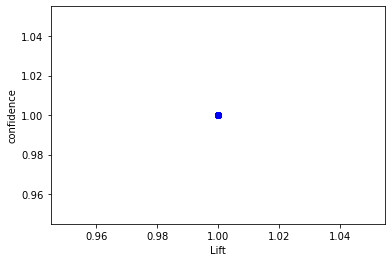

In [24]:
# write the code to show a scatter plot of the association rules
import matplotlib.pyplot as plt
x=[]
y=[]
with open(rules_path) as p:
    for line in p:
        x.append(float((line.split(",")[3])))
        y.append(float((line.split(",")[2])))

plt.scatter(x, y, c ="blue")

plt.xlabel("Lift")
plt.ylabel("confidence")
plt.show()

<h2>Sensitivity Analysis (10 Points)</h2>


<p style="text-align: justify;">Run the frequent pattern mining function with the following values of minimum support and measure the total number of frequent patterns and the execution time. Next, draw three line plots using the matplotlib library that shows how minimum support (the x-axis) affects the runtime and the frequent itemsets (the y-axis). Note that x and y axes must have proper titles.
    
Minimum support values:
    
    0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01


In [11]:
# write the code here
# you can insert more cells below, if needed

minList=[0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01]

freqItemSetList=[]
timeList=[]
for m in minList:
    start1 = time.time()
    freqItemSet, rules = fpgrowth(list1, m,min_confidence)
    elapsed_time = (round(time.time() - start1,2))
    timeList.append(elapsed_time)
    freqItemSetList.append(len(freqItemSet))



    

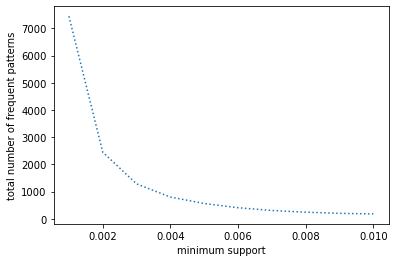

In [12]:
plt.plot(minList,freqItemSetList,  linestyle = 'dotted')
plt.xlabel("minimum support")
plt.ylabel("total number of frequent patterns")
plt.show()

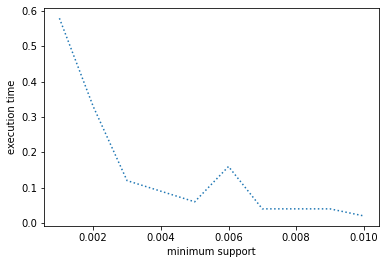

In [13]:
plt.plot(minList,timeList, linestyle = 'dotted')
plt.xlabel("minimum support")
plt.ylabel("execution time")
plt.show()

<h3>Coding Considerations</h3>
<p style="text-align: justify;">You must consider the following in your implementations:</p>
<ul>
<li class="a"><span> The output CSV files should be generated in the same directory of your code when you run it. Use the naming provided in the Implementation section. </span>
<li class="a"><span> You should write your code in this Jupyter Notebook (*.ipynb) file which can generate the required reports itself.</span>
<li class="a"><span> Your code should be self-explanatory. Make sure you add comments and your output files are formatted correctly. You might lose up to 30 points for bad code quality (readability, modularity, comments, efficiency, etc.) and formatting of the output files.</span></li>
</ul>

<h2>Submission</h2>
<p style="text-align: justify;">Your python file or Jupyter Notebook file must generate all the abovementioned reports when you run it.</p>
<p style="text-align: justify;">You need to submit a zip file in Canvas, including the following items: 

<ul>
<li class="a"><span> a Jupyter Notebook (*.ipynb) file, named assignment3.ipynb that contains your completed code </span>
<li class="a"><span> patterns.csv that contains the frequent patterns</span>
<li class="a"><span> negative.csv that contains the negative corelated frequent itemsets.</span>
<li class="a"><span> maximal.csv that contains the maximal patterns</span>
<li class="a"><span> rules.csv that contains the association rules</span>
<li class="a"><span> results.pdf: a pdf file that contains all the requested charts and outputs (only copy the outputs (not the code itself) from your Notebook to this file. Also do not include the patterns and their supports in this file.)</span>
    
</li>
</ul>
    
<span style="background-color: #ffff99;">The file name should be in <strong>FirstName_LastName</strong> format</span>.</p>
<p style="text-align: justify;"><span style="background-color: #ffff99;">DO NOT INCLUDE EXTRA FILES, SUCH AS THE INPUT DATASETS</span>, in your submission;</p>
<p style="text-align: justify;">Please download your assignment after submission and make sure it is not corrupted or empty! We will not be responsible for corrupted submissions and will not take a resubmission after the deadline.</p>

<h2>Need Help?</h2>
<p>If you need help with this assignment, please get in touch with TAs (on MS Teams or via email) or go to their office hours.</p>

<p>You are highly encouraged to ask your question on the designated channel for Assignment 3 on Microsoft Teams (not necessarily monitored by the instructor/TAs). Feel free to help other students with general questions. However, DO NOT share your solution.</p>